SERDS_Raman_Simulation_Main
============================

This script is the entry point for the SERDS Raman Simulation Project. It orchestrates the entire workflow—from dataset selection and simulation, through optional preprocessing, to modeling and plotting—allowing users to generate and analyze synthetic Raman and SERDS spectra under various fluorescence conditions.

**Workflow Overview:**

1. **Dataset Selection:**  
   The script presents six simulated datasets with different fluorescence characteristics:
   - **Dataset 1:** Simulated spectra with decay_rate = 0.
   - **Dataset 2:** Simulated spectra with decay_rate = 0.005.
   - **Dataset 3:** Simulated spectra with fluctuating spectral intensity.
   - **Dataset 4:** Simulated spectra with variable fluorescence shapes.
   - **Dataset 4a:** SERDS-only scenario with independently varying fluorescence shape for each laser and also each sample.
   - **Dataset 5:** Heterogeneous samples combining paired FSR levels.

2. **Data Retrieval/Generation:**  
   - **Existing Data:** If simulation data (spectra, fluorescence, wavelength values, and lambda values) is already saved, the script loads it.
   - **New Simulation:** Otherwise, it generates new simulation data using functions from the `simulation` module.

3. **Preprocessing (Optional):**  
   Users can choose to preprocess the data using one of two methods:
   - **DWT (Discrete Wavelet Transform)**
   - **ALS with advanced extrapolation** (recommended for datasets 4/4a)

4. **Modeling:**  
   The script builds Partial Least Squares Regression (PLSR) models to predict target variables:
   - For most datasets, a single PLSR component is used (Dataset 3 uses two).
   - Dataset 5 is modeled with a dedicated function to handle its heterogeneous nature.

5. **Plotting:**  
   Diagnostic plots are generated to visualize:
   - **Feature Importance:** Highlights significant spectral features.
   - **Calibration Curves:** Compares predicted vs. measured values.
   - **Publication Figures:** Special figures for Dataset 5 are created for inclusion in papers.

6. **Evaluation:**
An evaluation branch computes ensemble performance metrics. By performing model training over multiple randomized splits (e.g., 10 different random states), the script calculates the mean and standard deviation of RMSEP (and other error metrics) for each fluorescence scenario. The evaluation results are saved in a separate “Evaluation” folder under the dataset’s results folder.

7. **Output:**  
   All simulation data, modeling results, and plots are saved in the `Results/` directory (subfolders by dataset).

**Modules and Key Functions:**

- **utils/**
  - `file_io.py`: `save_simulation_data()`, `load_simulation_data()`
  - `datasets.py`: `get_dataset_info()`
  
- **simulation/**
  - `simulation_data.py`: `simulate_dataset12()`, `simulate_dataset3()`, `simulate_dataset4()`, `simulate_dataset4a()`, `simulate_dataset5()`
  
- **preprocessing/**
  - `pre_processing.py`: `preprocess_DWT()`, `preprocess_ALS()`, `preprocess_als_extrapolate()`, `asymmetric_least_squares()`, `dwt_iterative_bg_rm()`
  
- **modeling/**
  - `modeling.py`: `run_pls_modeling_all()`, `run_pls_modeling_dataset5()`
  
- **plotting/**
  - `plotting.py`: `plot_feature_importance()`, `plot_calibration()`, `plot_feature_importance_dataset5()`, `plot_calibration_dataset5()`, `plot_dataset5_paper_figure()`

- **evaluation/**

  - `evaluation.py`

**Usage Instructions:**



# 1. Import Libraries and Modules

In [4]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# --- Import functions from our modules ---
# Data processing (for loading and generating base data)
from data_processing.data_loader import data_loader_by_path, y_loader_by_path
from data_processing.synthetic_generation import gen_mix, plot_generated_y_histograms
from data_processing.spectral_processing import shifted_raman_spectra_generator, wavenumber_to_wavelength, wavelength_to_wavenumber
from data_processing.laser_experiment import laser_separation_experiment

# Plotting functions
from plotting.plotting import plot_synthetic_specs, plot_FSR_definition, plot_specs, plot_shifted_fluorescence_shapes

# Preprocessing/hyperparameter inspection (optional)
from preprocessing.hyperparameter_inspection import (
    plot_als_bg_removal_edge,
    plot_als_bg_removal_extrapolate,
    plot_dwt_bg_removal_inspection
)
from preprocessing.pre_processing import asymmetric_least_squares, norm_mean
from pathlib import Path
save_directory = Path("Results/Saved_Figures")



# 2.  Loading pure data (Raman: Benzophenone, DL-Alanine. Fluorecence: Oatmeal Agar)

In [6]:
# Load pure base data from a CSV file.
pure_data_path = 'pure_data_library/Pure_data_main_manuscript/pure_data_df.csv'
pure_data_df = pd.read_csv(pure_data_path)

# Extract pure fluorescence and pure Raman data.
pure_fluorescence = pure_data_df[['Oatmeal agar', 'Oatmeal agar (raw)']].values
pure_raman = pure_data_df[['Benzophenone', 'Alanine']].values.T  # Transpose so that rows correspond to different pure spectra

# Get wavenumber and wavelength arrays.
w_cm = pure_data_df['Wavenumber'].values
w_nm = pure_data_df['Wavelength'].values

print("Pure fluorescence shape:", pure_fluorescence.shape)
print("Pure Raman shape:", pure_raman.shape)
display(pure_data_df.head())

Pure fluorescence shape: (1024, 2)
Pure Raman shape: (2, 1024)


,Benzophenone,Alanine,Oatmeal agar,Oatmeal agar (raw),Wavenumber,Wavelength
0,1141.73,3833.875808,34997.08306,32600.56,267.101471,801.62
1,1195.18,4217.006021,35107.18236,34159.77,269.279758,801.76
2,1284.17,4643.638249,35218.86511,35044.96,271.457285,801.90
3,1424.28,5118.872500,35331.99583,35561.14,273.789505,802.05
4,1617.91,5581.408783,35446.43814,35907.77,275.965458,802.19


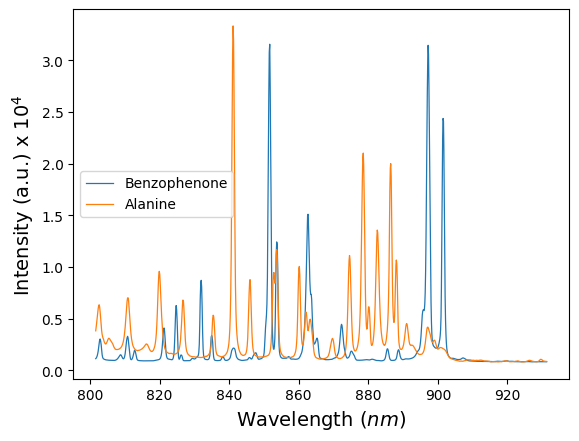

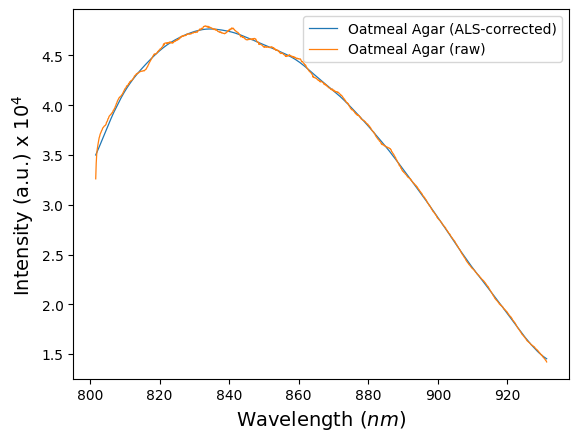

Initial FSR values = 1.438988197253652


In [7]:
pure_raman_names = ['Benzophenone', 'Alanine']
fluorescence_name = ['Oatmeal Agar (ALS-corrected)', 'Oatmeal Agar (raw)'] 
#Oatmeal Agar (ALS-corrected): noise free background for simulation
#Oatmeal_Agar_ALS-corrected = plot_ALS_snr_measurement(pure_fluorescence[:,1], lam=10**5, p=0.5, niter=10)
plot_specs(pure_raman, w_nm, id_list=pure_raman_names, show_labels=True)
plot_specs(pure_fluorescence.T, w_nm, id_list=fluorescence_name, show_labels=True)
print(f"Initial FSR values = {np.max(pure_fluorescence)/np.max(pure_raman)}") #1.428


# 2.  Generating synthetic binary mixtures

In [8]:
np.random.seed(42)
gen_spec, gen_y, gen_name = gen_mix(pure_raman, pure_raman_names, total_number=1000, dim=1024, y_columns=2)
print(gen_spec.shape, gen_y.shape)


(1000, 1024) (1000, 2)


In [9]:
np.mean(gen_y, axis=0)

array([0.51617775, 0.48382225])

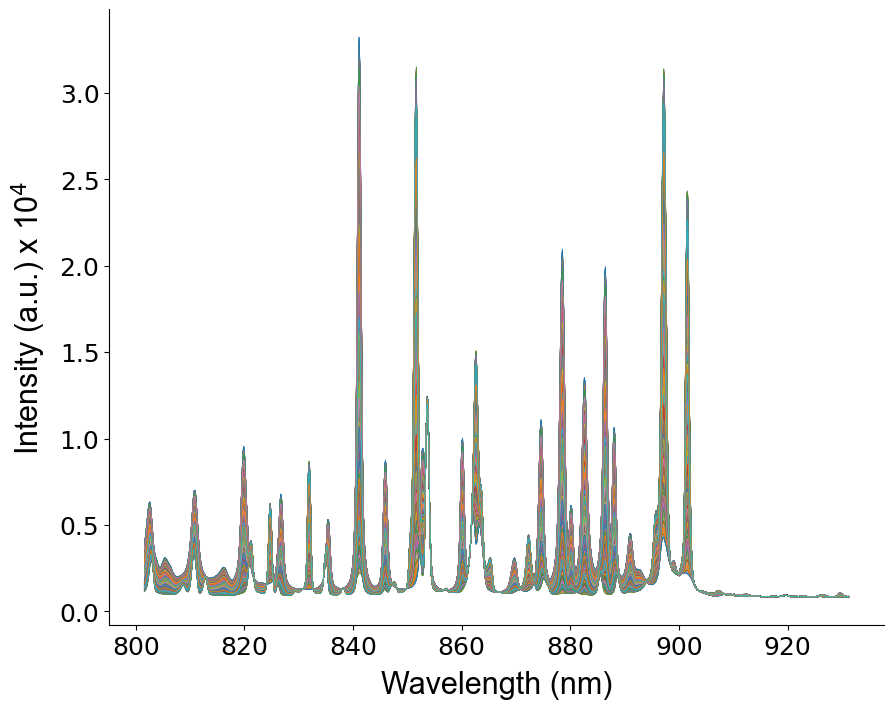

In [ ]:
plot_synthetic_specs(gen_spec, pure_fluorescence, w_nm,  save_path = save_directory / "pure_mixtures.png")

# Y proportions' histogram

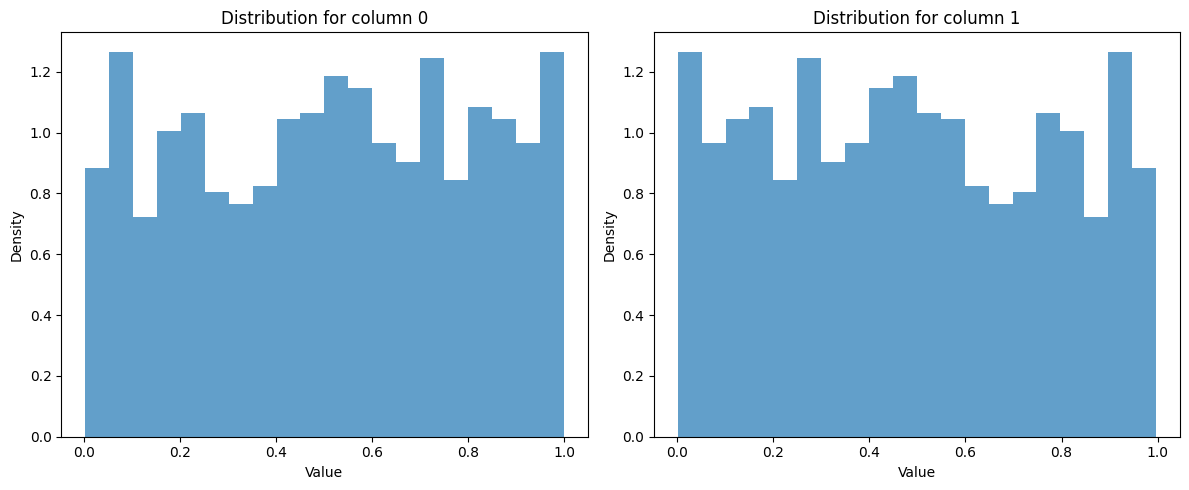

In [7]:

plot_generated_y_histograms(gen_y) 

# Paper Figure: FSR definition

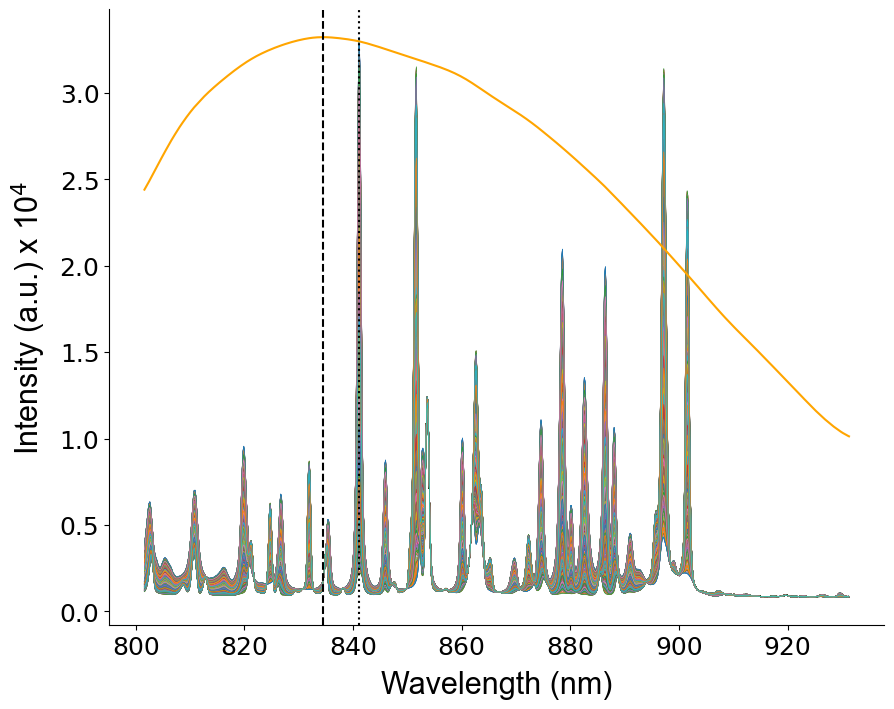

In [14]:
plot_FSR_definition(gen_spec,pure_fluorescence[:, 0].T, w_nm, save_path = save_directory / "FSR_definition.png")

# 3. Generating synthetic shifted excited Raman mixtures

(1000, 990)

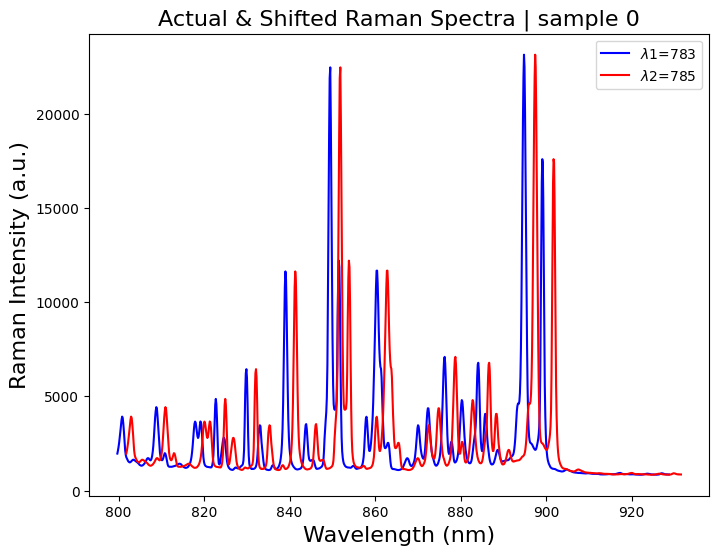

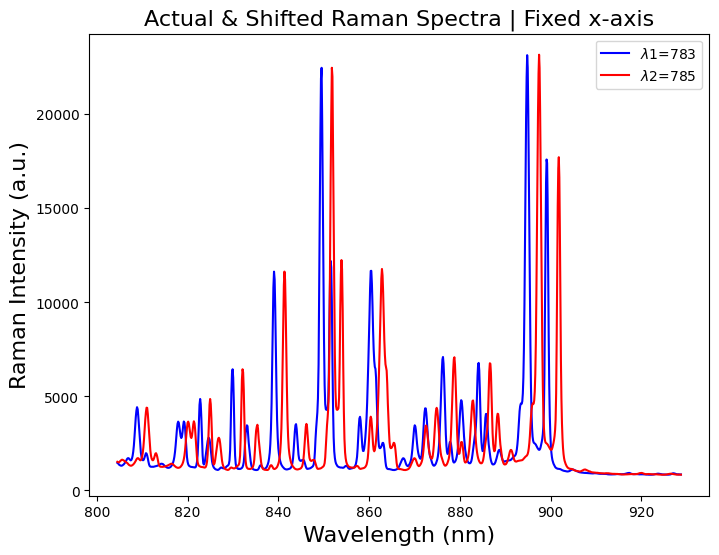

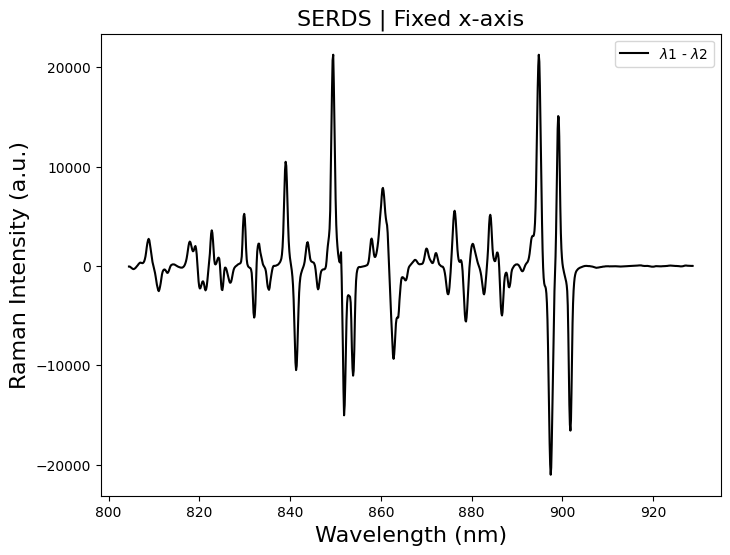

In [9]:
lambda_1 = 783 #excitation wavelength for laser 1 in nm
lambda_2 = 785 #excitation wavelength for laser 2 in nm
start, end = 34, 1024
wavelengths_new, specs_1_cut, specs_2_cut, fig1, fig2, fig3= shifted_raman_spectra_generator(
    w_cm, gen_spec, lambda_1, lambda_2, start=start, end=end, plot=True
)
specs_1_cut.shape



# SI Figure plot: Generate different fluorecence shapes

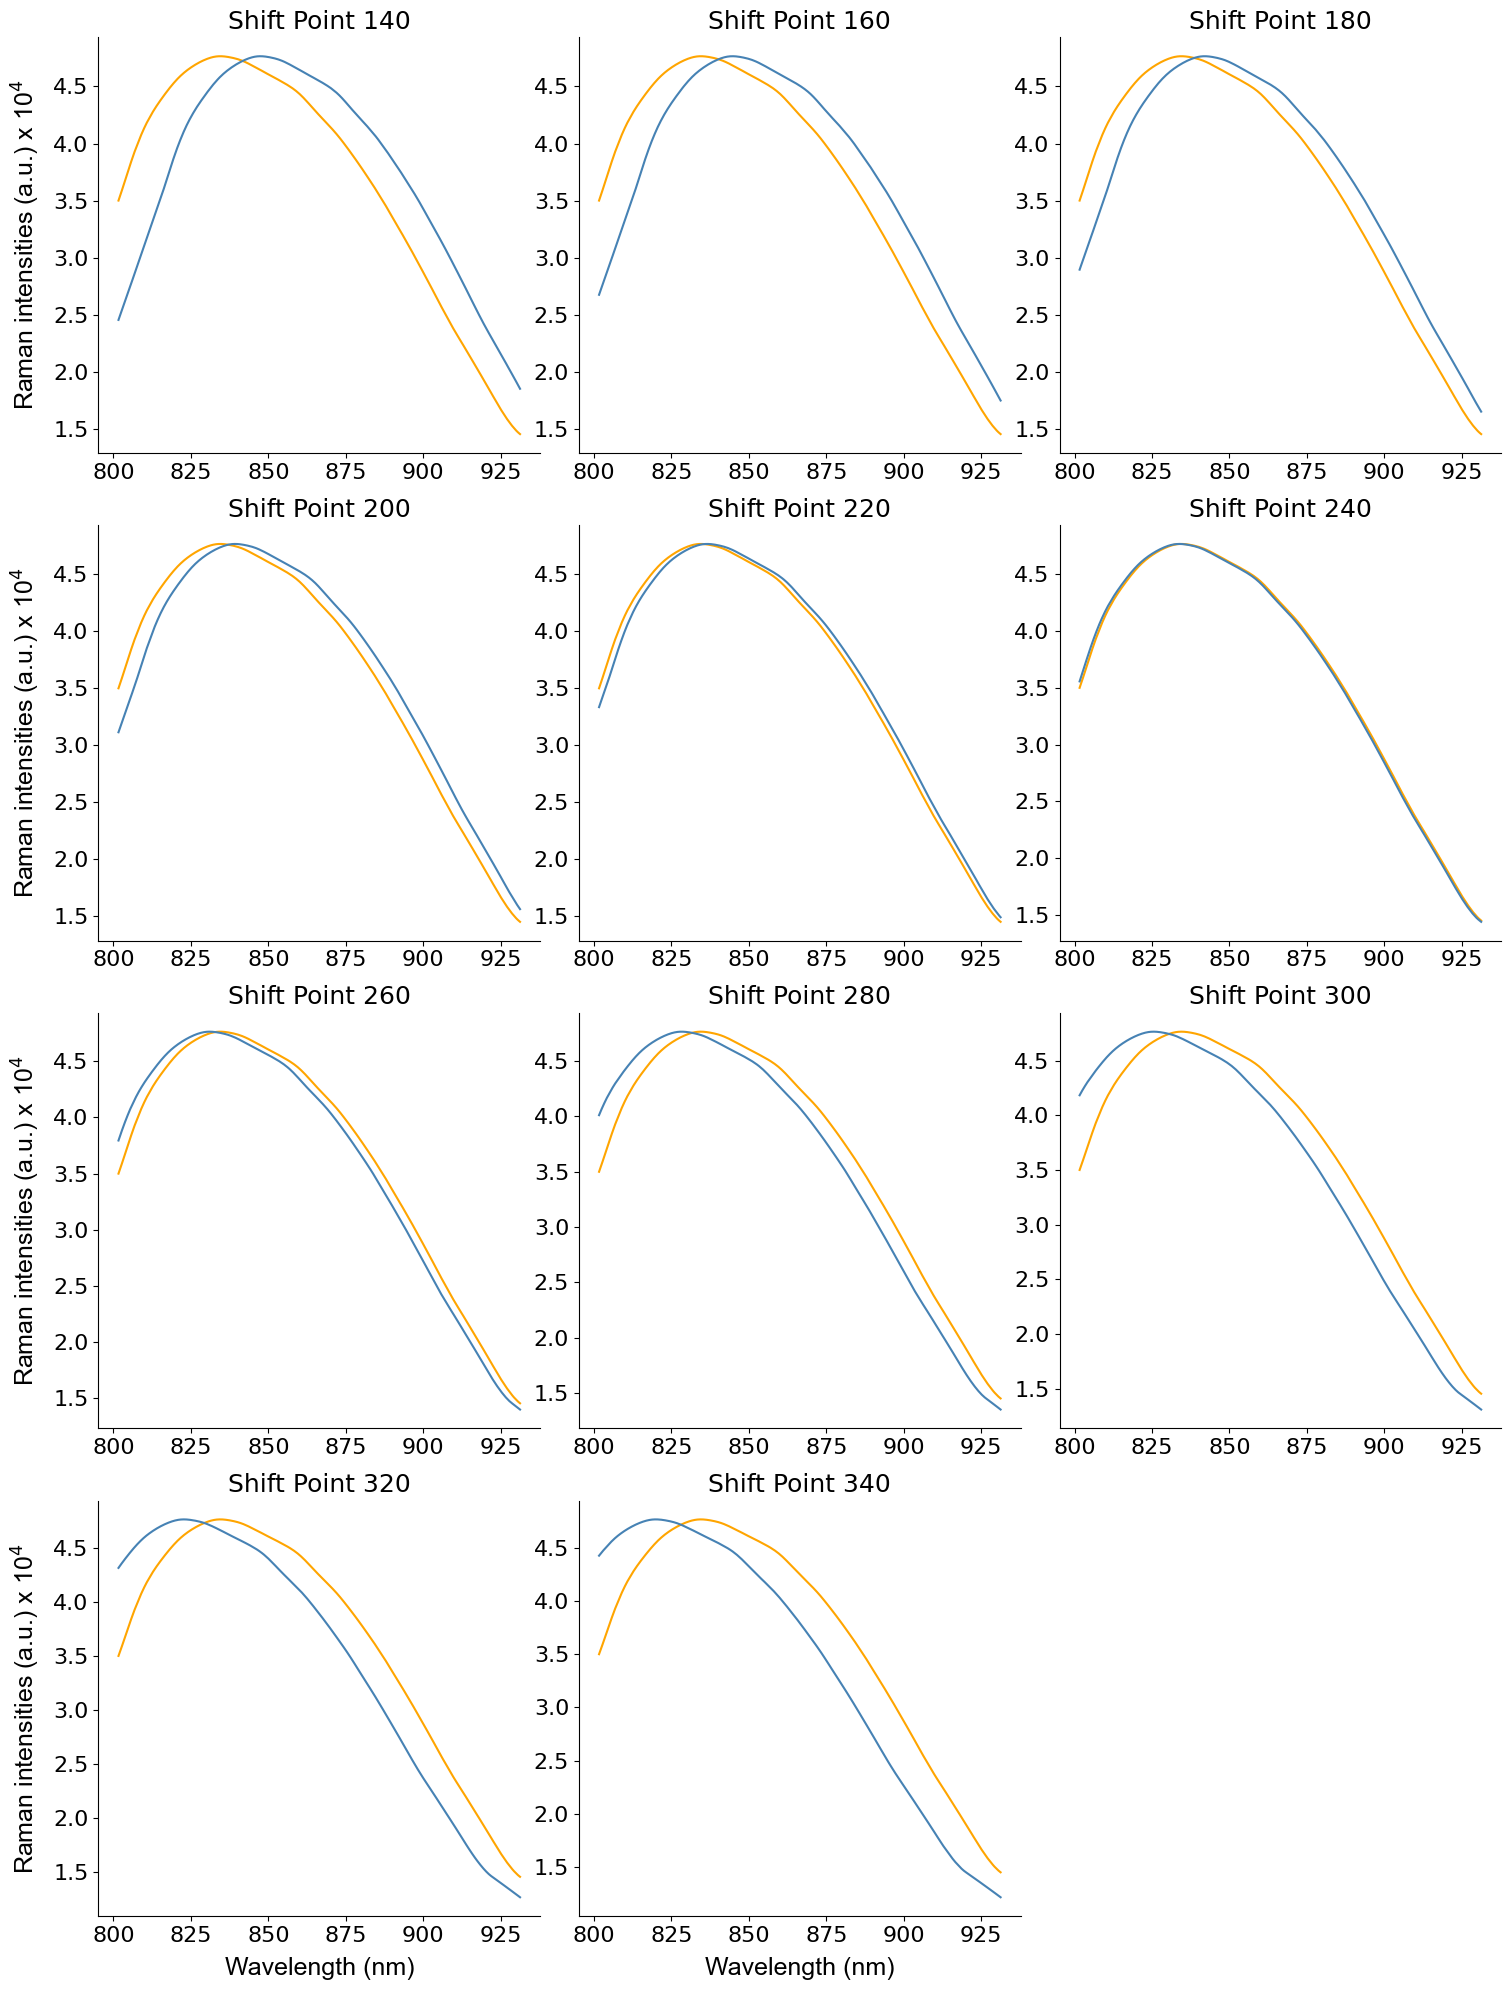

In [15]:
fig = plot_shifted_fluorescence_shapes(pure_fluorescence[:, 0].T, w_nm, save_path = save_directory / "F_shapes.png")

# 4. (main.py) Dataset generation, modeling, feature importance plots, calibration plots

Available Datasets:
  Dataset 1: Dataset 1: Simulated spectra with FSR values 0, 1, 10, 100, 1000, 2000, 3000, 4000 (decay_rate = 0).
  Dataset 2: Dataset 2: Same as Dataset 1 but with decay_rate = 0.005.
  Dataset 3: Dataset 3: Tests prediction accuracy under sample-to-sample fluctuating spectral intensity (random scaling factors ±1–50%) with decay_rate = 0.005.
  Dataset 4: Dataset 4: Represents granular natural systems with variable fluorescence shapes (100 shapes) from sample to sample with decay_rate = 0.005.
  Dataset 4a: Dataset 4a: A SERDS-only scenario with independently varying fluorescence shapes for each laser and each sample (11 shapes) with decay_rate = 0.005.
  Dataset 5: Dataset 5: Combines paired FSR levels (heterogeneous samples) to create training/validation sets, simulated with decay_rate = 0.005.
You selected Dataset 1: Dataset 1: Simulated spectra with FSR values 0, 1, 10, 100, 1000, 2000, 3000, 4000 (decay_rate = 0).
Loaded simulation data from file.

What result

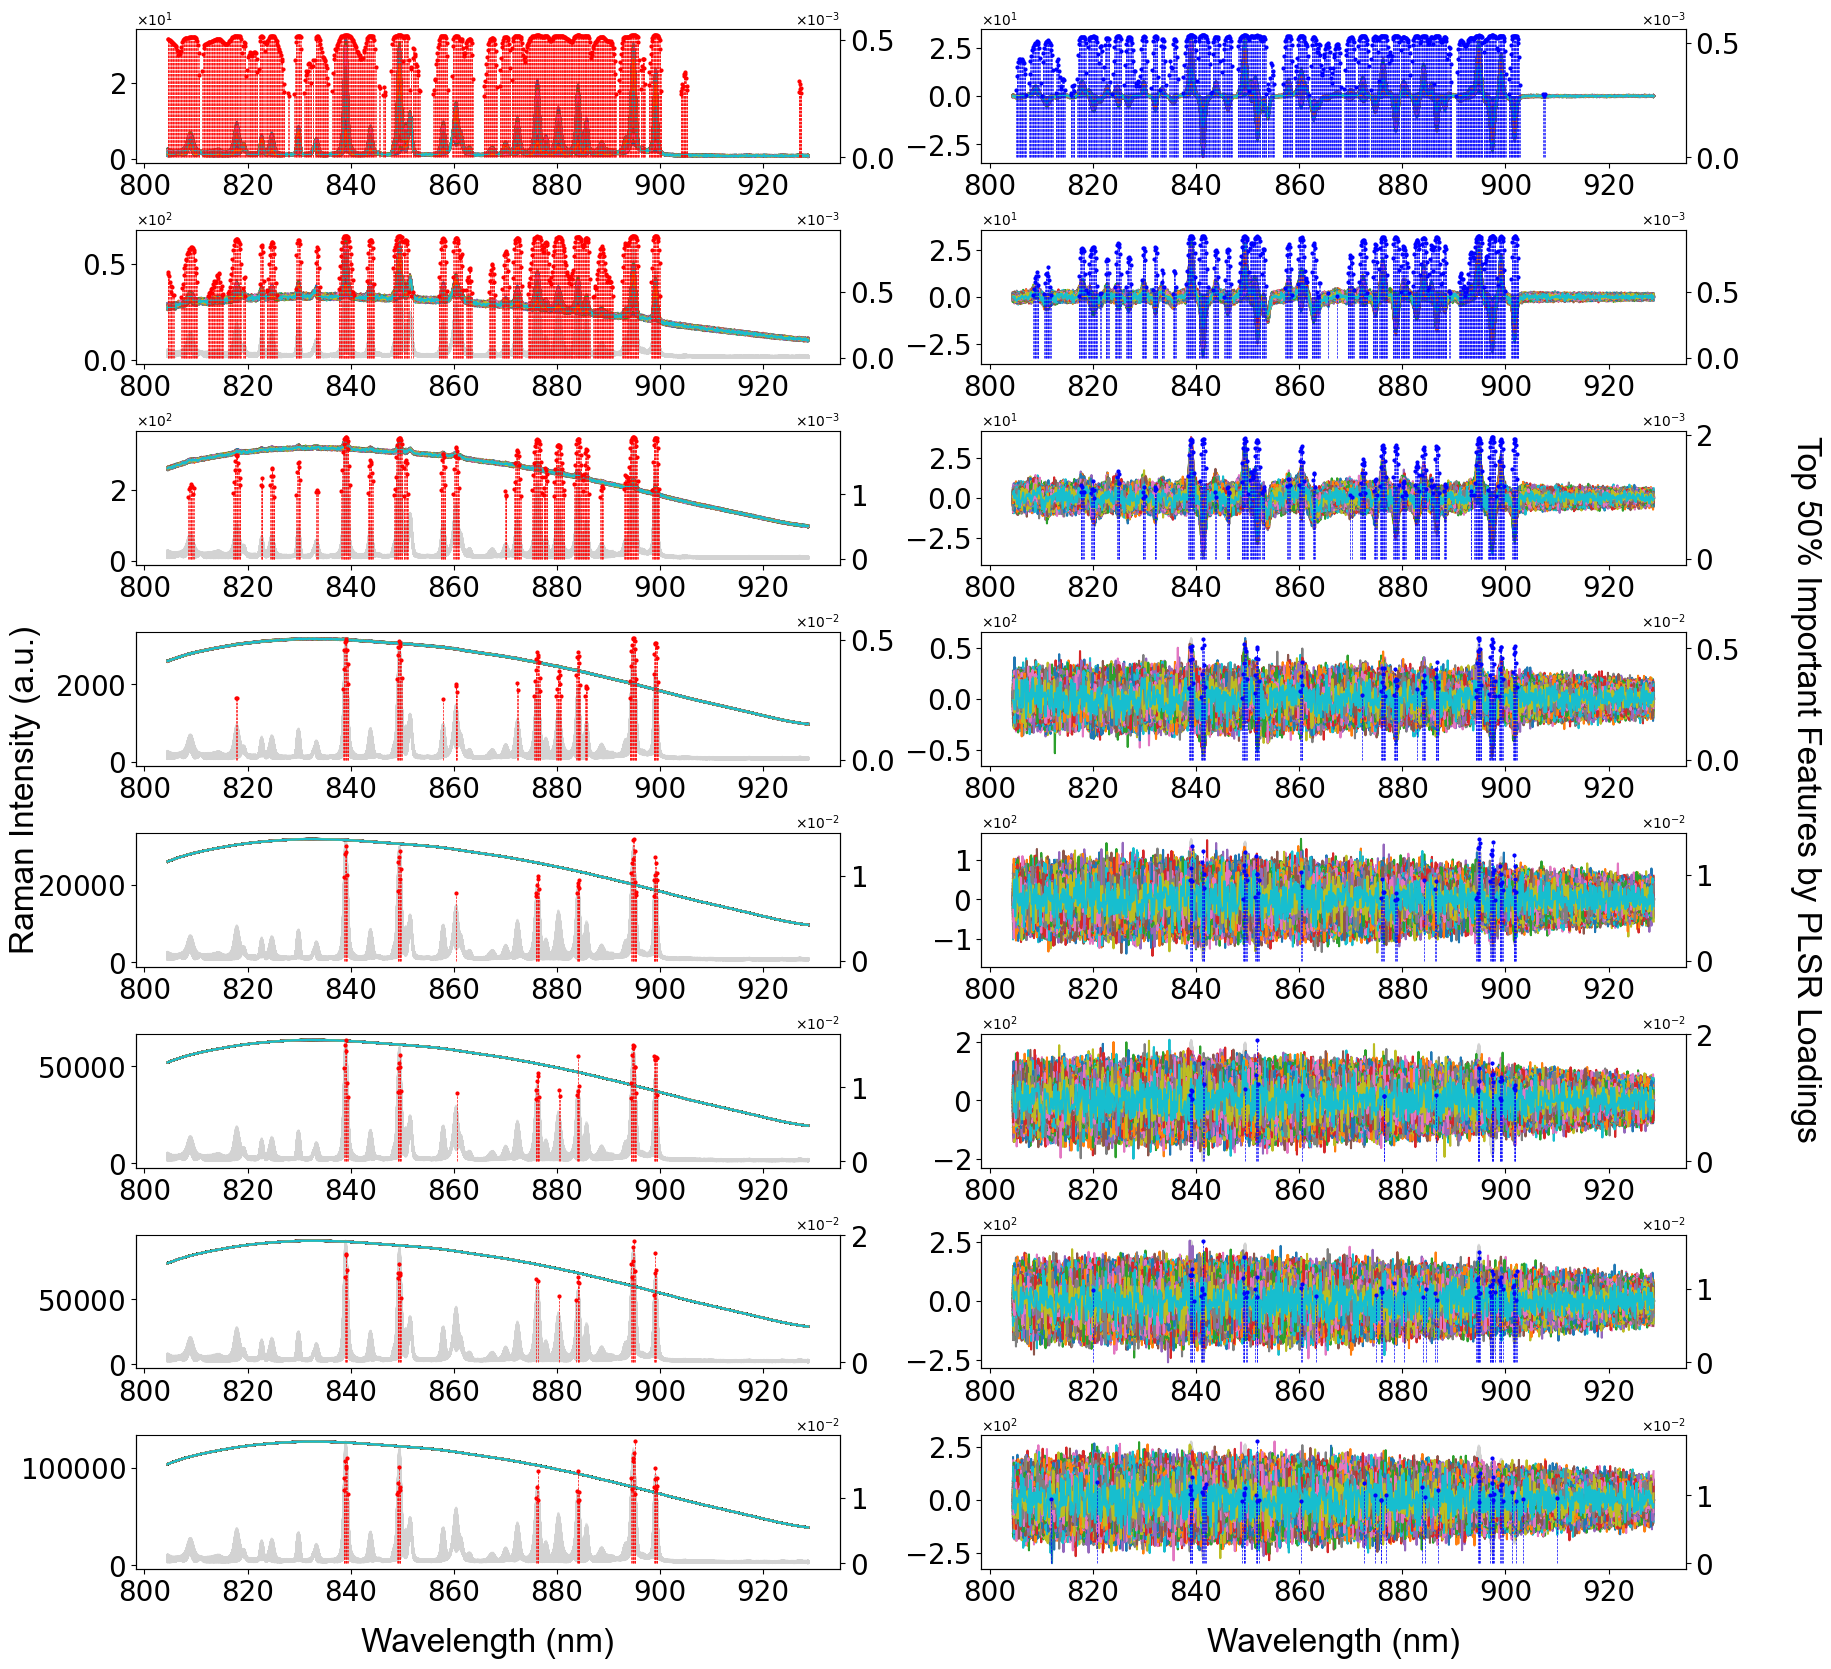

<Figure size 1000x800 with 0 Axes>

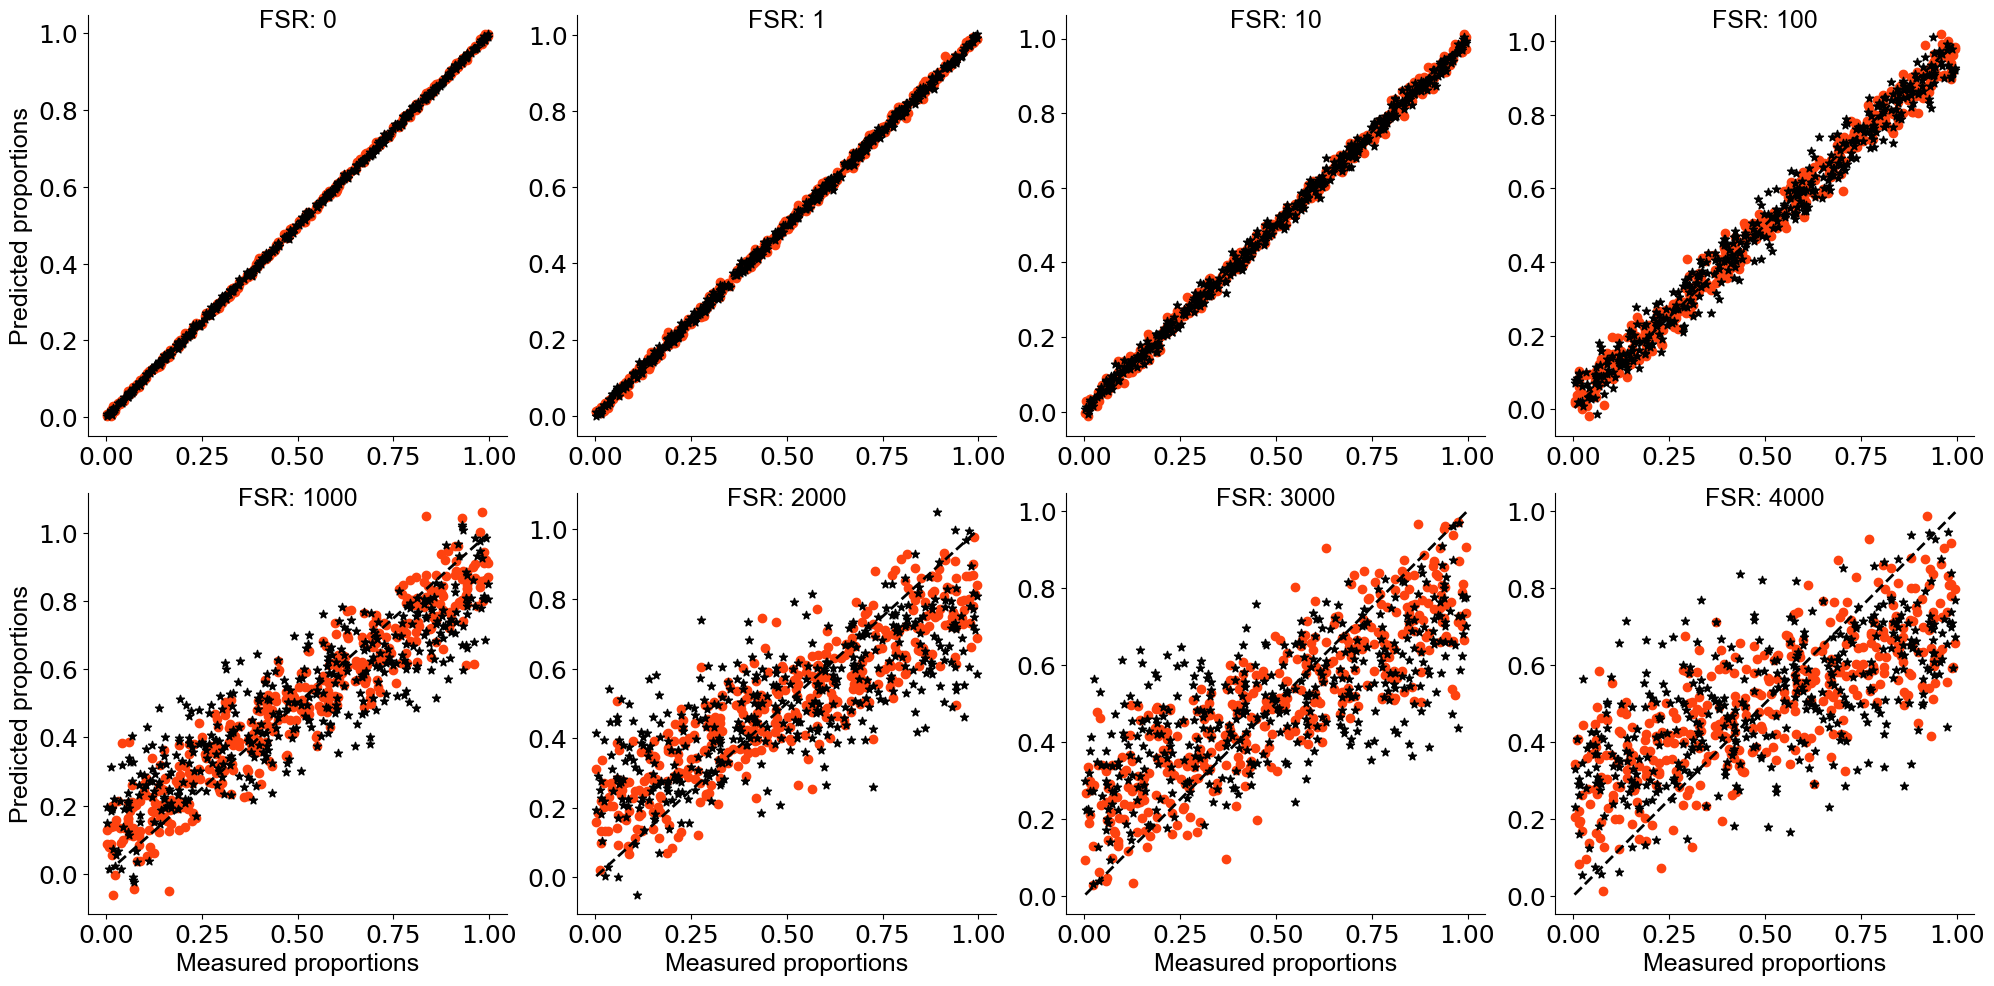

Processing complete. Check the Results folder for saved outputs.


<Figure size 1000x800 with 0 Axes>

In [ ]:
"""
main.py
-------
Entry point for the project. This script orchestrates dataset selection,
simulation, optional preprocessing (including advanced ALS extrapolation for datasets 4/4a),
modeling (PLSR), and plotting (feature importance, calibration, and paper figure for Dataset 5).

The available datasets are:
    1. Dataset 1: Simulated spectra with decay_rate = 0.
    2. Dataset 2: Simulated spectra with decay_rate = 0.005.
    3. Dataset 3: Simulated spectra with fluctuating spectral intensity.
    4. Dataset 4: Simulated spectra with variable fluorescence shapes.
    4a. Dataset 4a: SERDS-only scenario with independently varying fluorescence shapes.
    5. Dataset 5: Heterogeneous samples combining paired FSR levels.
"""

import os

def get_simulation_data():
    global specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new, lambda_1, lambda_2
    return specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new, lambda_1, lambda_2

# Import utility functions
from utils.file_io import save_simulation_data, load_simulation_data
from utils.datasets import get_dataset_info

# Import simulation functions
from simulation.simulation_data import (
    simulate_dataset12, simulate_dataset3, simulate_dataset4, simulate_dataset4a, simulate_dataset5
)

# Import preprocessing functions
from preprocessing.pre_processing import (
    preprocess_DWT, preprocess_ALS, preprocess_als_extrapolate, dwt_iterative_bg_rm
)

# Import modeling functions
from modeling.modeling import run_pls_modeling_all, run_pls_modeling_dataset5

# Import plotting functions
from plotting.plotting import (
    plot_feature_importance, plot_calibration, 
    plot_feature_importance_dataset5, plot_calibration_dataset5, plot_dataset5_paper_figure
)

from preprocessing.pre_processing import asymmetric_least_squares  # if defined here

def main():
    # Dataset selection
    datasets = get_dataset_info()
    print("Available Datasets:")
    for key, desc in datasets.items():
        print(f"  Dataset {key}: {desc}")
    dataset_key = input("Select a dataset (e.g., 1,2,3,4,4a,5): ").strip()
    print(f"You selected Dataset {dataset_key}: {datasets.get(dataset_key, 'Unknown dataset')}")
    
    # Retrieve simulation parameters (e.g., spectra, fluorescence, wavelengths, lambda values)
    specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new, lambda_1, lambda_2 = get_simulation_data()
    global gen_y #(target variable) is defined
    
    # Set number of PLSR components (Dataset 3 uses 2; others use 1)
    n_components = 2 if dataset_key == "3" else 1
    dataset_prefix = f"Dataset{dataset_key}"
    
    # Create folder for results for this dataset
    results_folder = os.path.join("Results", dataset_prefix)
    os.makedirs(results_folder, exist_ok=True)
    
    # Simulation data file
    sim_data_filename = os.path.join(results_folder, f"GeneratedData_{dataset_prefix}.pkl")
    
    if os.path.exists(sim_data_filename):
        sim_data = load_simulation_data(sim_data_filename)
        results_dict = sim_data["results_dict"]
        initial_F_levels = sim_data["initial_F_levels"] #[0, 1, 10, 100, 1000, 2000, 3000, 4000]  
        fluoro_shape = sim_data["fluoro_shape"]
        print("Loaded simulation data from file.")
    else:
        if dataset_key == "1":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset12(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean, decay_rate=0.0
            )
        elif dataset_key == "2":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset12(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean, decay_rate=0.005
            )
        elif dataset_key == "3":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset3(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean
            )
        elif dataset_key == "4":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset4(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean
            )
        elif dataset_key == "4a":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset4a(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean
            )
        elif dataset_key == "5":
            # For Dataset 5, simulate Dataset 2 first and then combine paired FSR levels.
            results_dict_2, init_F_levels_2, fluoro_shape_2 = simulate_dataset12(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean, decay_rate=0.005
            )
            results_dict = simulate_dataset5(results_dict_2, gen_y)
            initial_F_levels = list(results_dict.keys())
            fluoro_shape = fluoro_shape_2
        else:
            print("Invalid dataset selection. Exiting.")
            return
        
        sim_data = {"results_dict": results_dict, "initial_F_levels": initial_F_levels, "fluoro_shape": fluoro_shape}
        save_simulation_data(sim_data_filename, sim_data)
        print(f"Simulation data saved to {sim_data_filename}")
    
    # Decide what results to generate
    if dataset_key != "5":
        print("\nWhat results would you like to generate?")
        print("  1: Raw results (Simulation, PLSR Modeling, Feature Importance, Calibration)")
        print("  2: Preprocessed results (choose DWT or ALS)")
        print("  3: All (both raw and one preprocessed option)")
        result_choice = input("Enter your choice (1, 2, or 3): ").strip()
        
        if result_choice == "1":
            prefix = f"{dataset_prefix}_Raw"
            csv_dir = os.path.join(results_folder, f"{prefix}_PLSR")
            plsr_results_df, max_argmax_rmsep_df, feat_imp_dict = run_pls_modeling_all(
                results_dict, gen_y, initial_F_levels, test_size=0.2, random_state=42,
                n_components=n_components, csv_save_dir=csv_dir)
            fig1, axs1 = plot_feature_importance(
                results_dict, initial_F_levels, wavelengths_new, feat_imp_dict, max_argmax_rmsep_df,
                fig_save_path=os.path.join(results_folder, f"{prefix}_Feature_Importance.pdf"))
            fig2, axs2 = plot_calibration(
                plsr_results_df, calib_save_path=os.path.join(results_folder, f"{prefix}_calibration.pdf"))
        
        elif result_choice == "2":
            print("\nChoose a preprocessing method:")
            print("  1: DWT")
            print("  2: ALS (Extrapolate version for datasets 4/4a)")
            prep_choice = input("Enter your choice (1 or 2): ").strip()
            if prep_choice == "1":
                prefix = f"{dataset_prefix}_DWT"
                csv_dir = os.path.join(results_folder, f"{prefix}_PLSR")
                scales_dict = {
                    "1": [6, 6, 5, 5, 5, 5, 5, 5],
                    "2": [6, 6, 5, 5, 5, 5, 5, 5],
                    "3": [6, 6, 5, 5, 6, 6, 5, 5],
                    "4": [6, 6, 5, 5, 5, 5, 5, 5],
                    "4a": [6, 6, 5, 5, 5, 5, 5, 5]
                }
                scales = scales_dict.get(dataset_key, [6, 6, 5, 5, 5, 5, 5, 5])
                dwt_preprocessed = preprocess_DWT(results_dict, initial_F_levels, scales, dwt_iterative_bg_rm)
                plsr_results_dwt, max_argmax_rmsep_dwt, feat_imp_dwt = run_pls_modeling_all(
                    dwt_preprocessed, gen_y, initial_F_levels, test_size=0.2, random_state=42,
                    n_components=n_components, csv_save_dir=csv_dir)
                fig_dwt, axs_dwt = plot_feature_importance(
                    dwt_preprocessed, initial_F_levels, wavelengths_new, feat_imp_dwt, max_argmax_rmsep_dwt,
                    fig_save_path=os.path.join(results_folder, f"{prefix}_Feature_Importance.pdf"))
                fig_cal_dwt, axs_cal_dwt = plot_calibration(
                    plsr_results_dwt, calib_save_path=os.path.join(results_folder, f"{prefix}_calibration.pdf"))
            elif prep_choice == "2":
                prefix = f"{dataset_prefix}_ALS"
                csv_dir = os.path.join(results_folder, f"{prefix}_PLSR")
                pad_length = 200
                als_preprocessed = preprocess_als_extrapolate(results_dict, initial_F_levels, pad_length, asymmetric_least_squares)
                plsr_results_als, max_argmax_rmsep_als, feat_imp_als = run_pls_modeling_all(
                    als_preprocessed, gen_y, initial_F_levels, test_size=0.2, random_state=42,
                    n_components=n_components, csv_save_dir=csv_dir)
                fig_als, axs_als = plot_feature_importance(
                    als_preprocessed, initial_F_levels, wavelengths_new, feat_imp_als, max_argmax_rmsep_als,
                    fig_save_path=os.path.join(results_folder, f"{prefix}_Feature_Importance.pdf"))
                fig_cal_als, axs_cal_als = plot_calibration(
                    plsr_results_als, calib_save_path=os.path.join(results_folder, f"{prefix}_calibration.pdf"))
            else:
                print("Invalid choice. Exiting.")
                return
        elif result_choice == "3":
            prefix_raw = f"{dataset_prefix}_Raw"
            csv_dir = os.path.join(results_folder, f"{prefix_raw}_PLSR")
            plsr_results_df, max_argmax_rmsep_df, feat_imp_dict = run_pls_modeling_all(
                results_dict, gen_y, initial_F_levels, test_size=0.2, random_state=42,
                n_components=n_components, csv_save_dir=csv_dir)
            fig1, axs1 = plot_feature_importance(
                results_dict, initial_F_levels, wavelengths_new, feat_imp_dict, max_argmax_rmsep_df,
                fig_save_path=os.path.join(results_folder, f"{prefix_raw}_Feature_Importance.pdf"))
            fig2, axs2 = plot_calibration(
                plsr_results_df, calib_save_path=os.path.join(results_folder, f"{prefix_raw}_calibration.pdf"))
            print("\nNow choose a preprocessing method for additional results:")
            print("  1: DWT")
            print("  2: ALS (Extrapolate version for datasets 4/4a)")
            prep_choice = input("Enter your choice (1 or 2): ").strip()
            if prep_choice == "1":
                prefix_prep = f"{dataset_prefix}_DWT"
                csv_dir = os.path.join(results_folder, f"{prefix_prep}_PLSR")
                scales_dict = {
                    "1": [6, 6, 5, 5, 5, 5, 5, 5],
                    "2": [6, 6, 5, 5, 5, 5, 5, 5],
                    "3": [6, 6, 5, 5, 6, 6, 5, 5],
                    "4": [6, 6, 5, 5, 5, 5, 5, 5],
                    "4a": [6, 6, 5, 5, 5, 5, 5, 5]
                }
                scales = scales_dict.get(dataset_key, [6, 6, 5, 5, 5, 5, 5, 5])
                dwt_preprocessed = preprocess_DWT(results_dict, initial_F_levels, scales, dwt_iterative_bg_rm)
                plsr_results_dwt, max_argmax_rmsep_dwt, feat_imp_dwt = run_pls_modeling_all(
                    dwt_preprocessed, gen_y, initial_F_levels, test_size=0.2, random_state=42,
                    n_components=n_components, csv_save_dir=csv_dir)
                fig_dwt, axs_dwt = plot_feature_importance(
                    dwt_preprocessed, initial_F_levels, wavelengths_new, feat_imp_dwt, max_argmax_rmsep_dwt,
                    fig_save_path=os.path.join(results_folder, f"{prefix_prep}_Feature_Importance.pdf"))
                fig_cal_dwt, axs_cal_dwt = plot_calibration(
                    plsr_results_dwt, calib_save_path=os.path.join(results_folder, f"{prefix_prep}_calibration.pdf"))
            elif prep_choice == "2":
                prefix_prep = f"{dataset_prefix}_ALS"
                csv_dir = os.path.join(results_folder, f"{prefix_prep}_PLSR")
                pad_length = 200
                als_preprocessed = preprocess_als_extrapolate(results_dict, initial_F_levels, pad_length, asymmetric_least_squares)
                plsr_results_als, max_argmax_rmsep_als, feat_imp_als = run_pls_modeling_all(
                    als_preprocessed, gen_y, initial_F_levels, test_size=0.2, random_state=42,
                    n_components=n_components, csv_save_dir=csv_dir)
                fig_als, axs_als = plot_feature_importance(
                    als_preprocessed, initial_F_levels, wavelengths_new, feat_imp_als, max_argmax_rmsep_als,
                    fig_save_path=os.path.join(results_folder, f"{prefix_prep}_Feature_Importance.pdf"))
                fig_cal_als, axs_cal_als = plot_calibration(
                    plsr_results_als, calib_save_path=os.path.join(results_folder, f"{prefix_prep}_calibration.pdf"))
            else:
                print("Invalid choice. Exiting.")
                return
        else:
            print("Invalid result choice. Exiting.")
            return
    else:
        # For Dataset 5, use dedicated functions.
        prefix = f"{dataset_prefix}_Raw"
        csv_dir = os.path.join(results_folder, f"{prefix}_PLSR")
        plsr_results_df, _, _ = run_pls_modeling_dataset5(
            results_dict, gen_y, test_size=0.2, random_state=42,
            n_components=n_components, csv_save_dir=csv_dir)
        fig_cal, axs_cal = plot_calibration_dataset5(
            plsr_results_df, calib_save_path=os.path.join(results_folder, f"{prefix}_calibration.pdf"))
        # For the paper figure, assume results_dict_2 exists (or re-use results_dict if applicable)
        raw_results_dict_2 = {}
        for F in [0, 1]:
            raw_results_dict_2[F] = results_dict[F]
        pad_length = 200
        als_preprocessed_dict = preprocess_ALS(raw_results_dict_2, [0, 1], pad_length, asymmetric_least_squares)
        fig_paper, axs_paper = plot_dataset5_paper_figure(
            raw_results_dict_2, als_preprocessed_dict, wavelengths_new,
            fig_save_path=os.path.join(results_folder, f"{prefix}_PaperFigure.pdf"))
    
    print("Processing complete. Check the Results folder for saved outputs.")

if __name__ == '__main__':
    main()


# 5. (main_eval.py) Predictive accuracyusing a training ensemble with 10 randomized splits, computing RMSEP’s mean and standard deviation for each fluorescence scenario

In [ ]:
"""
main_eval.py
-------
Entry point for the project. This script orchestrates dataset selection,
simulation, optional preprocessing (including advanced ALS extrapolation for datasets 4/4a),
modeling (PLSR), plotting, and model evaluation (ensemble performance metrics).

The available datasets are:
    1. Dataset 1: Simulated spectra with decay_rate = 0.
    2. Dataset 2: Simulated spectra with decay_rate = 0.005.
    3. Dataset 3: Simulated spectra with fluctuating spectral intensity.
    4. Dataset 4: Simulated spectra with variable fluorescence shapes.
    4a. Dataset 4a: SERDS-only scenario with independently varying fluorescence shapes.
    5. Dataset 5: Heterogeneous samples combining paired FSR levels.
"""

import os

# Define get_simulation_data (assumed to be set in prior cells or in this script)
def get_simulation_data():
    global specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new, lambda_1, lambda_2
    return specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new, lambda_1, lambda_2

# Import utility functions
from utils.file_io import save_simulation_data, load_simulation_data
from utils.datasets import get_dataset_info

# Import simulation functions
from simulation.simulation_data import (
    simulate_dataset12, simulate_dataset3, simulate_dataset4, simulate_dataset4a, simulate_dataset5
)

# Import preprocessing functions
from preprocessing.pre_processing import (
    preprocess_DWT, preprocess_ALS, preprocess_als_extrapolate, dwt_iterative_bg_rm, asymmetric_least_squares
)

# Import modeling functions
from modeling.modeling import run_pls_modeling_all, run_pls_modeling_dataset5

# Import plotting functions
from plotting.plotting import (
    plot_feature_importance, plot_calibration, 
    plot_feature_importance_dataset5, plot_calibration_dataset5, plot_dataset5_paper_figure
)

# Import evaluation function from evaluation module
from evaluation.evaluation import evaluate_pls_variability

def main():
    # Dataset selection
    datasets = get_dataset_info()
    print("Available Datasets:")
    for key, desc in datasets.items():
        print(f"  Dataset {key}: {desc}")
    dataset_key = input("Select a dataset (e.g., 1,2,3,4,4a,5): ").strip()
    print(f"You selected Dataset {dataset_key}: {datasets.get(dataset_key, 'Unknown dataset')}")
    
    # Retrieve simulation parameters (e.g., spectra, fluorescence, wavelengths, lambda values)
    specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new, lambda_1, lambda_2 = get_simulation_data()
    global gen_y  # (target variable) is assumed to be defined in a previous cell
    
    # Set number of PLSR components (Dataset 3 uses 2; others use 1)
    n_components = 2 if dataset_key == "3" else 1
    dataset_prefix = f"Dataset{dataset_key}"
    
    # Create folder for results for this dataset
    results_folder = os.path.join("Results", dataset_prefix)
    os.makedirs(results_folder, exist_ok=True)
    
    # Simulation data file
    sim_data_filename = os.path.join(results_folder, f"GeneratedData_{dataset_prefix}.pkl")
    
    if os.path.exists(sim_data_filename):
        sim_data = load_simulation_data(sim_data_filename)
        results_dict = sim_data["results_dict"]
        initial_F_levels = sim_data["initial_F_levels"]
        fluoro_shape = sim_data["fluoro_shape"]
        print("Loaded simulation data from file.")
    else:
        if dataset_key == "1":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset12(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean, decay_rate=0.0
            )
        elif dataset_key == "2":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset12(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean, decay_rate=0.005
            )
        elif dataset_key == "3":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset3(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean
            )
        elif dataset_key == "4":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset4(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean
            )
        elif dataset_key == "4a":
            results_dict, initial_F_levels, fluoro_shape = simulate_dataset4a(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean
            )
        elif dataset_key == "5":
            # For Dataset 5, simulate Dataset 2 first and then combine paired FSR levels.
            results_dict_2, init_F_levels_2, fluoro_shape_2 = simulate_dataset12(
                specs_1_cut, specs_2_cut, pure_fluorescence, wavelengths_new,
                lambda_1, lambda_2, norm_mean, decay_rate=0.005
            )
            from some_target_module import gen_y  # Ensure gen_y is defined/available
            results_dict = simulate_dataset5(results_dict_2, gen_y)
            initial_F_levels = list(results_dict.keys())
            fluoro_shape = fluoro_shape_2
        else:
            print("Invalid dataset selection. Exiting.")
            return
        
        sim_data = {"results_dict": results_dict, "initial_F_levels": initial_F_levels, "fluoro_shape": fluoro_shape}
        save_simulation_data(sim_data_filename, sim_data)
        print(f"Simulation data saved to {sim_data_filename}")
    
    print("\nWhat would you like to do?")
    print("  1: Generate simulation and modeling results")
    print("  2: Evaluate model variability (across random states)")
    option = input("Enter your choice (1 or 2): ").strip()
    
    if option == "1":
        # Existing modeling and plotting code goes here.
        print("Generating simulation and modeling results... (this branch is not shown in full here)")
        # Example
        # prefix = f"{dataset_prefix}_Raw"
        # csv_dir = os.path.join(results_folder, f"{prefix}_PLSR")
        # plsr_results_df, max_argmax_rmsep_df, feat_imp_dict = run_pls_modeling_all(
        #     results_dict, gen_y, initial_F_levels, test_size=0.2, random_state=42,
        #     n_components=n_components, csv_save_dir=csv_dir)
        # fig1, axs1 = plot_feature_importance(
        #     results_dict, initial_F_levels, wavelengths_new, feat_imp_dict, max_argmax_rmsep_df,
        #     fig_save_path=os.path.join(results_folder, f"{prefix}_Feature_Importance.pdf"))
        # fig2, axs2 = plot_calibration(
        #     plsr_results_df, calib_save_path=os.path.join(results_folder, f"{prefix}_calibration.pdf"))
        pass
    elif option == "2":
        # Evaluation mode: compute ensemble metrics across several random splits without plotting.
        eval_folder = os.path.join(results_folder, "Evaluation")
        eval_df = evaluate_model_performance(results_dict, gen_y, initial_F_levels, n_components, eval_folder)
        print("Evaluation results:")
        print(eval_df)
    else:
        print("Invalid option. Exiting.")
        return

    print("Processing complete. Check the Results folder for saved outputs.")

if __name__ == '__main__':
    main()


# SI figure plot: ALS and DWT optimal hyperparameter selection inspection and ALS edge padding effect

In [ ]:
from preprocessing import plot_als_bg_removal_edge, plot_als_bg_removal_extrapolate, plot_dwt_bg_removal_inspection
from preprocessing.pre_processing import asymmetric_least_squares, dwt_iterative_bg_rm
from preprocessing.hyperparameter_inspection import advanced_extrapolate  # if defined there

# For ALS with edge padding:
fig_edge, axs_edge = plot_als_bg_removal_edge(results_dict, initial_F_levels, asymmetric_least_squares, pad_length=200,
                                              save_path='Results_Figures/als_edge.pdf')

# For ALS with extrapolated padding:
fig_extrap, axs_extrap = plot_als_bg_removal_extrapolate(results_dict, initial_F_levels, asymmetric_least_squares,
                                                        advanced_extrapolate, pad_length=200,
                                                        save_path='Results_Figures/als_extrap.pdf')

# For DWT BG removal inspection:
# For example, plot for first 4 fluorescence levels with provided scales:
scales = [6, 6, 5, 5]  # Adjust scales as needed
fig_dwt, axs_dwt = plot_dwt_bg_removal_inspection(results_dict, initial_F_levels, scales, dwt_iterative_bg_rm,
                                                  start=0, end=4, save_path='Results_Figures/dwt_inspection.pdf')


# The End
